In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import os
import time
import tensorflow as tf
from IPython import display

In [2]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4 * 4 * 256, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh'))
    return model

In [3]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [4]:
generator = make_generator()
discriminator = make_discriminator()

C:\Users\Dav0\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Dav0\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [10]:
EPOCHS = 900
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

In [12]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch)
        if (epoch + 1) % 50 == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 50 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print(f'Time for epoch {epoch + 1} is {time.time()-start:.2f} sec')
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [13]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img_array = (predictions[i].numpy() * 127.5 + 127.5).astype(np.uint8)
        plt.imshow(img_array)
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [14]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

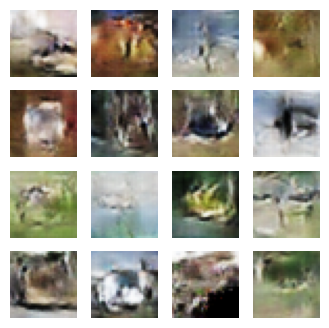

In [15]:
train(train_dataset, EPOCHS)

In [17]:
# Пути для сохранения весов
generator_weights_path = 'generator.weights.h5'
discriminator_weights_path = 'discriminator.weights.h5'

# Сохранение весов моделей в корневой папке проекта
generator.save_weights(generator_weights_path)
discriminator.save_weights(discriminator_weights_path)
